# Policy-Based Reinforcement Learning for CartPole

This notebook demonstrates how to use policy-based reinforcement learning (REINFORCE) to solve the CartPole-v1 environment using TensorFlow. It includes reward curve visualization and a GIF of the agent's final performance.
- install dependencies: pip install tensorflow gymnasium[classic-control] IPython matplotlib
- packages version: tensorflow-2.18.0 gymnasium-1.0.0

In [2]:
!pip install gymnasium[classic-control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import gymnasium as gym
from IPython.display import clear_output
import matplotlib.pyplot as plt

## 1. Environment Setup

In [4]:
env = gym.make('CartPole-v1')
num_actions = env.action_space.n
state_size = env.observation_space.shape[0]

## 2. Build Policy Network

In [5]:

# Neural network for policy
def build_policy_network(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', name='Hidden_Layer'))  # Hidden layer
    model.add(Dense(output_dim, activation='softmax', name='Output_Layer'))  # Output layer
    return model

## 3. Define the Function to Calculate Discounted Rewards

In [6]:
# Function to compute discounted rewards
def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    cumulative_reward = 0
    for t in reversed(range(len(rewards))):
        cumulative_reward = rewards[t] + gamma * cumulative_reward
        discounted_rewards[t] = cumulative_reward
    return discounted_rewards

## 4. Training Loop

In [9]:
# Train the Cart-Pole environment
def train_cartpole():
    env = gym.make("CartPole-v1")
    input_dim = env.observation_space.shape[0]  # State size (4)
    output_dim = env.action_space.n  # Action size (2)
    policy_network = build_policy_network(input_dim, output_dim)  # Build policy network
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  # Optimizer
    gamma = 0.99  # Discount factor

    rewards_history = []  # Store total rewards for each episode

    for episode in range(200):  # Number of episodes
        state, _ = env.reset()
        states = []
        actions = []
        rewards = []
        total_reward = 0

        # Generate an episode
        while True:
            # print(f"State Type: {type(state)}, State Shape: {len(state)}, State: {state}")

            state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)  # Convert state to tensor
            action_probs = policy_network(state_tensor)  # Get action probabilities
            action = np.random.choice(output_dim, p=action_probs.numpy().squeeze())  # Sample action
            next_state, reward, done, truncated, _ = env.step(action)  # Take the action

            # Store trajectory
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            total_reward += reward
            state = next_state

            if done or truncated:
                break

        # Compute discounted rewards
        discounted_rewards = compute_discounted_rewards(rewards, gamma)
        discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-8)  # Normalize rewards

        # Perform policy gradient update
        with tf.GradientTape() as tape:
            loss = 0
            for state, action, reward in zip(states, actions, discounted_rewards):
                state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
                action_probs = policy_network(state_tensor)
                log_prob = tf.math.log(action_probs[0, action])
                loss -= log_prob * reward  # Negative because we minimize loss

        grads = tape.gradient(loss, policy_network.trainable_variables)
        optimizer.apply_gradients(zip(grads, policy_network.trainable_variables))

        rewards_history.append(total_reward)  # Store total reward
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

        # # Stop training once the environment is solved
        # if total_reward >= 200:
        #     print(f"Solved after {episode + 1} episodes!")
        #     break

    return policy_network, rewards_history

policy, rewards_history = train_cartpole()

Episode 1: Total Reward = 13.0
Episode 2: Total Reward = 16.0
Episode 3: Total Reward = 22.0
Episode 4: Total Reward = 33.0
Episode 5: Total Reward = 13.0
Episode 6: Total Reward = 11.0
Episode 7: Total Reward = 26.0
Episode 8: Total Reward = 24.0
Episode 9: Total Reward = 35.0
Episode 10: Total Reward = 10.0
Episode 11: Total Reward = 21.0
Episode 12: Total Reward = 9.0
Episode 13: Total Reward = 11.0
Episode 14: Total Reward = 11.0
Episode 15: Total Reward = 21.0
Episode 16: Total Reward = 11.0
Episode 17: Total Reward = 50.0
Episode 18: Total Reward = 12.0
Episode 19: Total Reward = 18.0
Episode 20: Total Reward = 11.0
Episode 21: Total Reward = 25.0
Episode 22: Total Reward = 15.0
Episode 23: Total Reward = 11.0
Episode 24: Total Reward = 28.0
Episode 25: Total Reward = 15.0
Episode 26: Total Reward = 21.0
Episode 27: Total Reward = 14.0
Episode 28: Total Reward = 34.0
Episode 29: Total Reward = 41.0
Episode 30: Total Reward = 34.0
Episode 31: Total Reward = 15.0
Episode 32: Total 

## 5. Show the Reward Curve

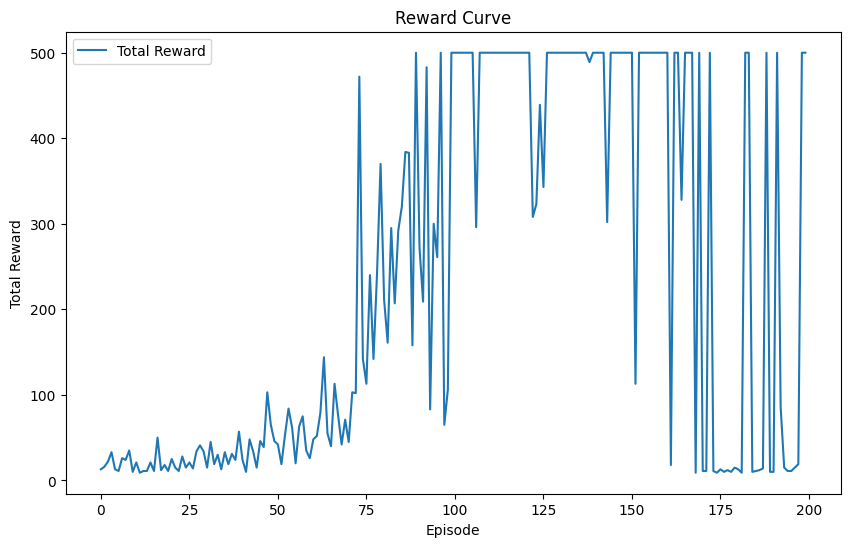

In [10]:
# Plot the reward curve
plt.figure(figsize=(10, 6))
plt.plot(rewards_history, label="Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Curve")
plt.legend()
plt.show()

## 6. Play Cart-pole with Trained Policy and Display it in Jupyter and Colab

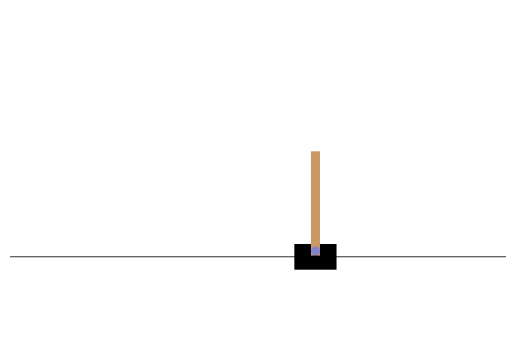

Final Performance: Total Reward = 500.0


In [11]:
# Function to visualize Cart-Pole performance
def play_cartpole(policy_network):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    state, _ = env.reset()
    total_reward = 0
    done = False
    truncated = False
    frames = []  # Store frames for visualization

    while not (done or truncated):
        # Render the environment
        frame = env.render()
        frames.append(frame)

        # Select action using the trained policy
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        action_probs = policy_network(state_tensor)
        action = np.argmax(action_probs.numpy().squeeze())  # Choose the best action
        state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
    env.close()

    return frames, total_reward

# Function to display animation in Colab
def display_animation(frames):
    for frame in frames:
        clear_output(wait=True)
        plt.imshow(frame)
        plt.axis('off')
        plt.show()

frames, total_reward = play_cartpole(policy)
display_animation(frames)
print(f"Final Performance: Total Reward = {total_reward}")